# Frost Weather Data
By: Magnus Kvåle Helliesen

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import toml
from datetime import date
from ipywidgets import interact, SelectMultiple
from mpl_toolkits.basemap import Basemap
from statsmodels.tsa.arima.model import ARIMA
from math import pi

In [12]:
# Credentials from https://frost.met.no/auth/requestCredentials.html
with open('credentials.toml', 'r') as file:
    credentials = toml.load(file)

## Finding list of stations and choosing using widget

In [13]:
endpoint = 'https://frost.met.no/sources/v0.jsonld'

parameters = {
    'types': 'SensorSystem',
    'validtime': '2000-01-01/2010-01-01'
}

r = requests.get(endpoint, parameters, auth=(credentials.get('credentials').get('client_id'),''))

json = r.json()

In [14]:
# Get all stations owned by MET.NO that are still up and running
df_stations = pd.json_normalize(json.get('data')).explode('stationHolders').query('stationHolders == "MET.NO"')
df_stations = df_stations[df_stations['validTo'].isna()]
df_stations = df_stations.sort_values('shortName')

In [15]:
# Make a dict with station id and name pairs
names_id = {x: y for x, y in zip(df_stations['shortName'], df_stations['id'])}
id_names = {val: key for key, val in names_id.items()}

# Choose stations from menu widget
@interact(id=SelectMultiple(options=names_id, rows=20))
def select_station(id):
    global stations
    stations = id
    display(df_stations[df_stations['id'].isin(id)].T.style.hide(axis='columns'))

interactive(children=(SelectMultiple(description='id', options={'Alta LH': 'SN93140', 'Andøya LH': 'SN87110', …

In [16]:
# Override widgets above, comment out if widget input is wanted
stations = [
    'SN50540',
    'SN25830',
    'SN41770',
    'SN82290',
    'SN99910',
    'SN68860',
    'SN90450',
    'SN18700'
]

## Showing locations on map

In [17]:
# Get marker data for map from dataframe
markers = []
for station in stations:
    markers += [df_stations[df_stations['id'] == station][['shortName', 'geometry.coordinates']].values.flatten().tolist()]

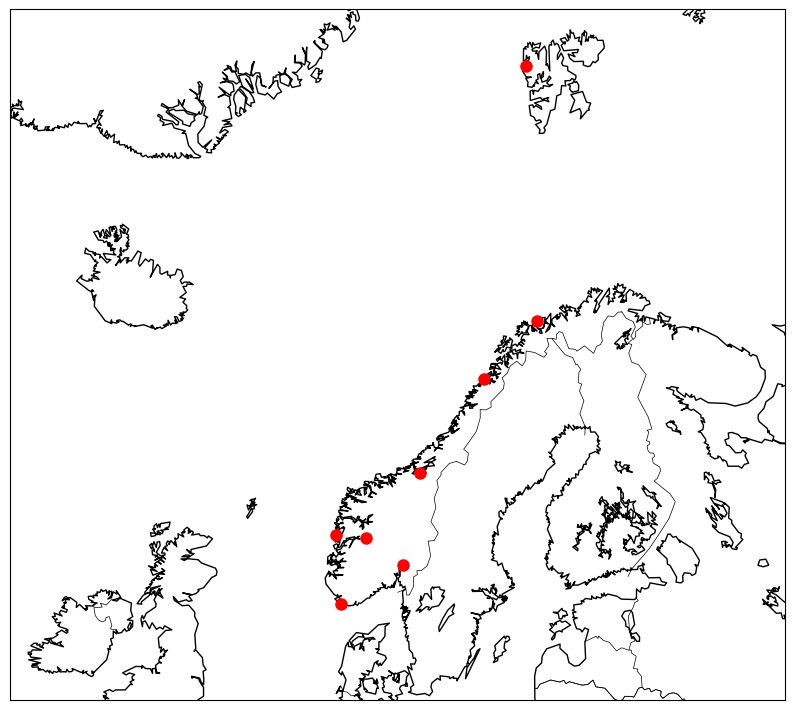

In [18]:
# Create a figure
plt.figure(figsize=(10, 10))

# Create a Basemap with extended boundaries to include Svalbard and Jan Mayen
map = Basemap(
    projection='aeqd',
    lat_0=60, lon_0=25,
    resolution='l',
    area_thresh=1000.0,
    llcrnrlon=-10,
    llcrnrlat=50,
    urcrnrlon=64,
    urcrnrlat=79
)

# Draw coastline and political boundaries
map.drawcoastlines()
map.drawcountries()

# Add points (latitude and longitude) to the map
points = [x[1][::-1] for x in markers]

lats, lons = zip(*points)
x, y = map(lons, lats)

# Plot points on the map
map.plot(x, y, 'ro', markersize=8)

plt.show()

## Retrieving data using FROST API

In [19]:
endpoint = 'https://frost.met.no/observations/v0.jsonld'

parameters = {
    'sources': ','.join(stations),
    'elements': 'mean(air_temperature P1D)',
    'referencetime': f'1990-01-01/{date.today()}'
}

r = requests.get(endpoint, parameters, auth=(credentials.get('credentials').get('client_id'),''))

if r.status_code == 200:
    json = r.json()
else:
    raise ValueError('No data retrieved')

In [20]:
# Store JSON to DataFrame and do some data wrangling
df = pd.json_normalize(json.get('data'), 'observations', ['sourceId', 'referenceTime'])
df = df[['sourceId', 'referenceTime', 'value']]
df['sourceId'] = df['sourceId'].str[:-2]
df = df.groupby(['sourceId', 'referenceTime'], as_index=False).mean()
df['referenceTime'] = pd.PeriodIndex(df['referenceTime'], freq='d')
df = df.pivot(index='referenceTime', columns='sourceId', values='value')

sourceId
SN18700    float64
SN25830    float64
SN41770    float64
SN50540    float64
SN68860    float64
SN82290    float64
SN90450    float64
SN99910    float64
dtype: object

In [ ]:
df.summary()

In [21]:
df.tail()

sourceId,SN18700,SN25830,SN41770,SN50540,SN68860,SN82290,SN90450,SN99910
referenceTime,,,,,,,,
2023-11-14,-0.90,-7.35,2.35,3.30,-3.35,-2.75,-5.05,-13.35
2023-11-15,-2.25,-8.20,1.80,1.55,-5.25,-4.40,-2.00,-15.35
2023-11-16,-3.55,-9.20,1.05,2.80,-7.25,-3.40,-1.00,-13.55
2023-11-17,-3.25,-14.15,0.40,0.50,-5.75,0.30,-0.50,-11.75
2023-11-18,-6.50,-15.50,1.90,0.95,-5.70,1.95,-1.45,-13.90


## Looking at the data

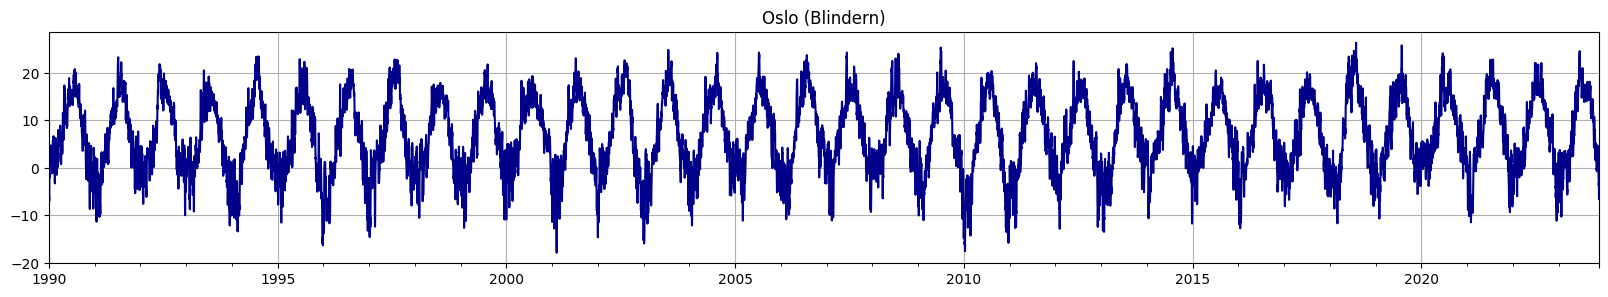

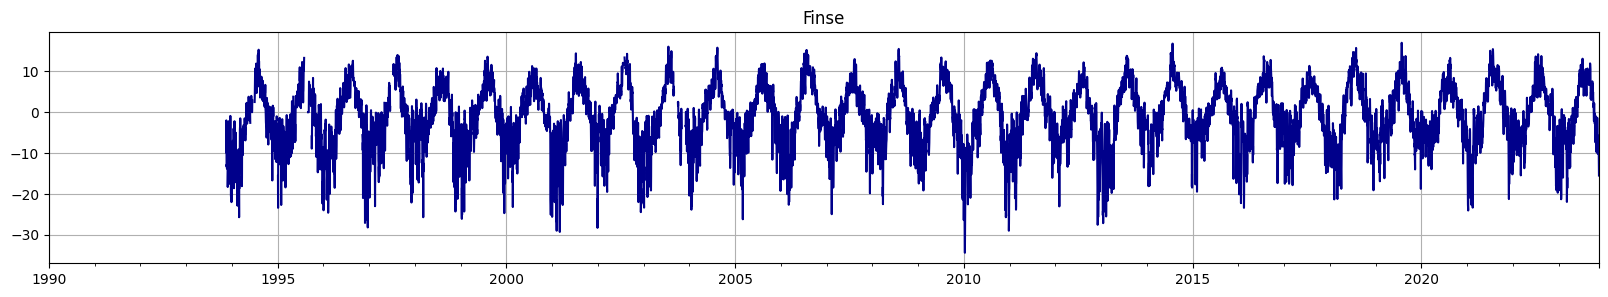

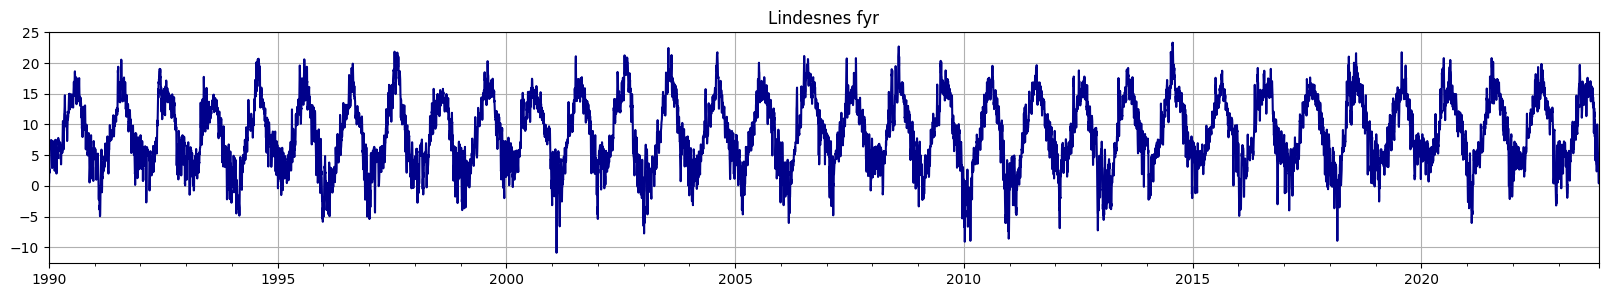

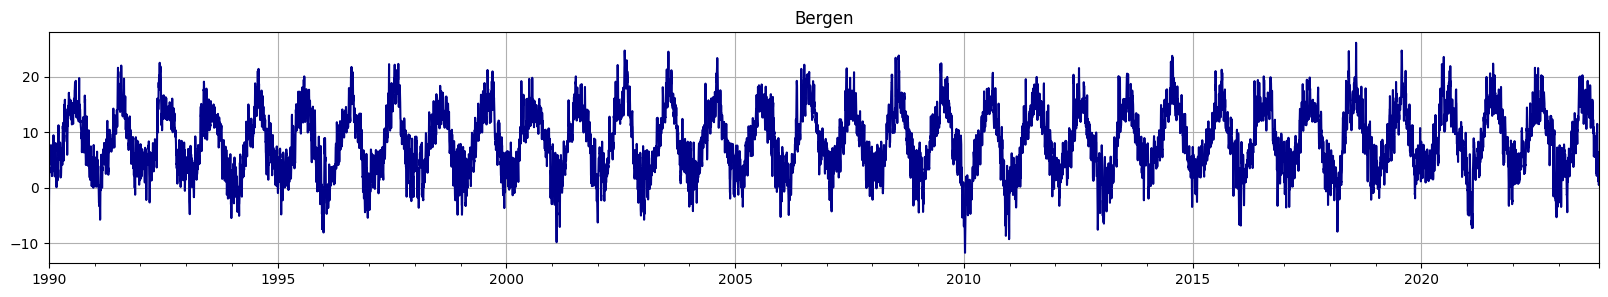

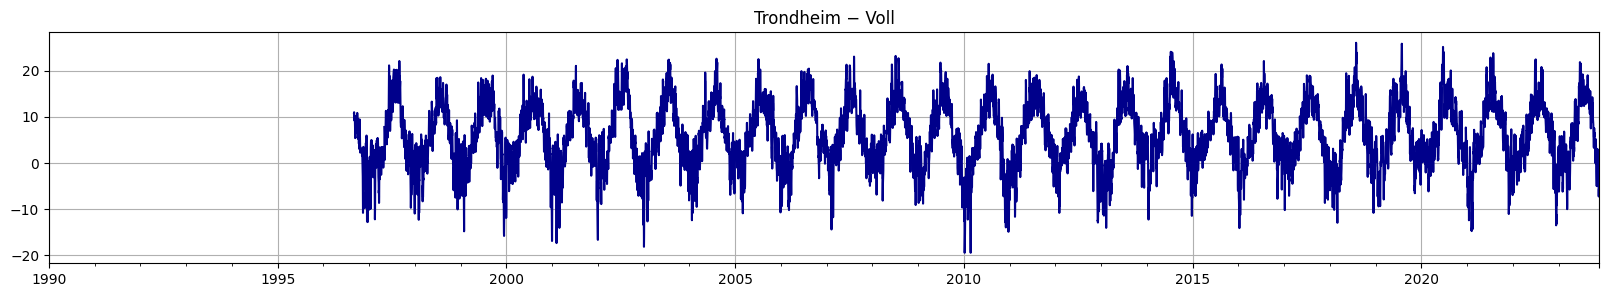

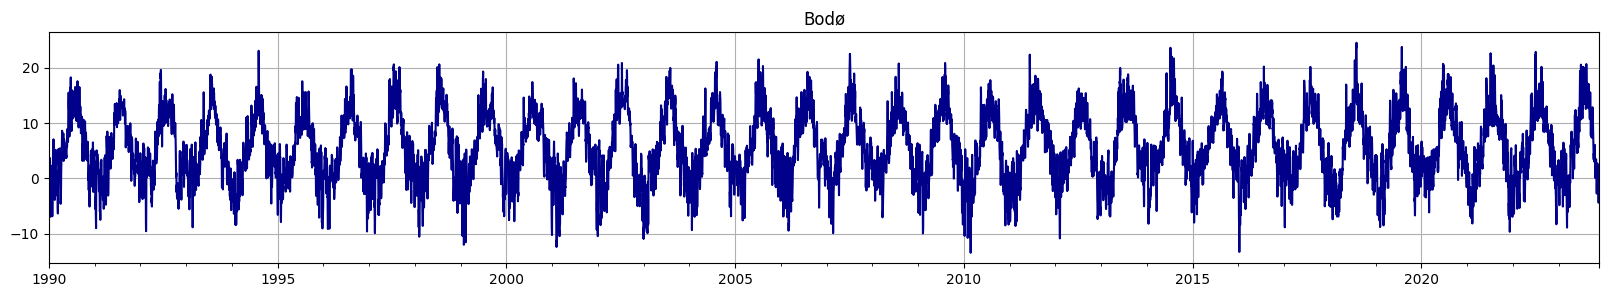

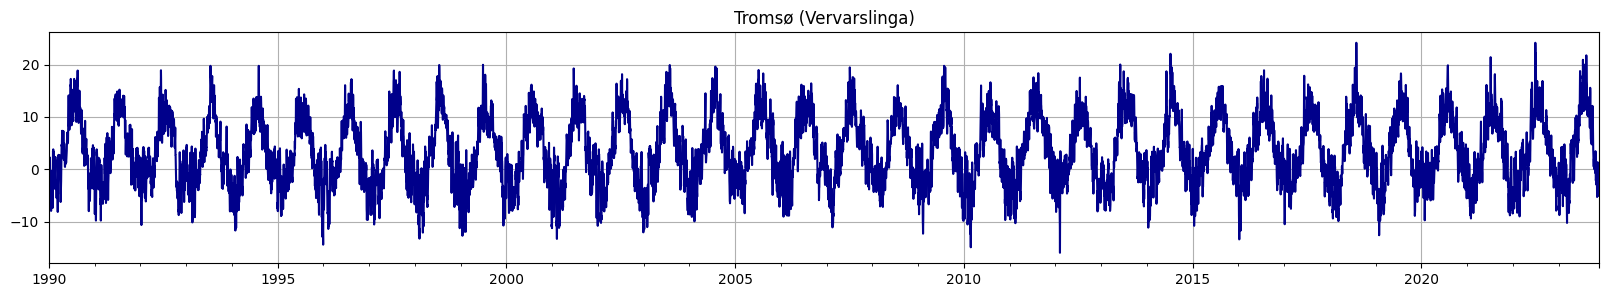

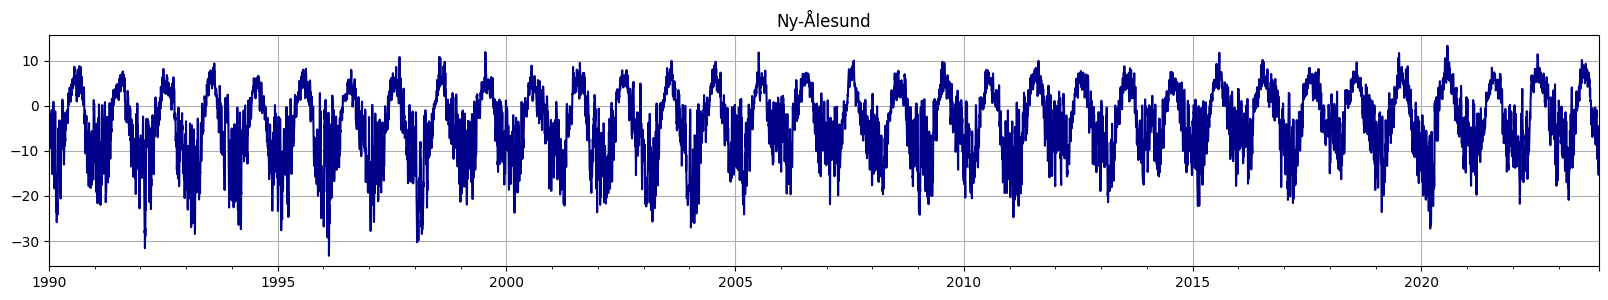

In [22]:
# Plot temperature time-series for selected stations
for i, col in enumerate(df.columns):
    plt.figure(figsize=(20, 3))
    plt.axhline(y=0, color='r', linestyle='-')
    df.iloc[:, i].plot(
        color='darkblue',
        xlabel='',
        grid=True,
        title=id_names.get(col)
        )
    plt.show()

## Forecasting using regression + ARIMA model

We want to forecast the temperature $Y_t$ assuming
$$
    Y_t = c+\beta_{\sin}\sin\left(2\pi\frac{d(t)}{365.25}\right)+\beta_{\cos}\cos\left(2\pi\frac{d(t)}{365.25}\right)+\varepsilon_t,
$$
where
$$
    (1-L)^d\Phi(L)\varepsilon_t=\Theta(L)\eta_t,\ \eta_t\sim\mathcal{N}(0, \sigma^2).
$$
That is: temperature varies, on average, like sine/cosine over the seasons around the level $c$; the deviations from the average temperature follow an ARIMA(p, d, q)-process. The function $d(t)$ maps the time index (or date) $t$ to the *day-of-year*, i.e., $d(t)\in [1, 366]$.

In [23]:
# We account for seasonality using sine and cosine as regressors
df_exog = pd.DataFrame(index=df.index)
df_exog['sin'] = np.sin(2*pi*df_exog.index.day_of_year/365.25)
df_exog['cos'] = np.cos(2*pi*df_exog.index.day_of_year/365.25)

In [24]:
# Run an ARIMA(p,d,q) on all columns and store model ARIMA objects in a dict
models = {}
for col in df.columns:
    model = ARIMA(df[col], exog=df_exog, order=(0,0,7), trend='c')
    models[col] = model

In [25]:
# Make a dict comprehension that fits each of the ARIMA models
fits = {key: val.fit() for key, val in models.items()}

In [26]:
# Print the results for all ARIMA-models
[val.summary() for _, val in fits.items()]

[<class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                SN18700   No. Observations:                12375
 Model:                 ARIMA(3, 0, 0)   Log Likelihood              -23170.719
 Date:                Sun, 19 Nov 2023   AIC                          46355.438
 Time:                        09:28:42   BIC                          46407.402
 Sample:                    01-01-1990   HQIC                         46372.843
                          - 11-18-2023                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const          6.9972      0.108     64.879      0.000       6.786       7.209
 sin           -2.9816      0.151    -19.681      0.000      -3.278   

In [27]:
# Function that returns forecasts a chosen number of days ahead
def forecast(days):
    # We make sine and cosine functions the chosen number of days ahead
    df_exog_forecast = pd.DataFrame(index=pd.period_range(start=df_exog.index.max()+1, periods=days, freq='d'))
    df_exog_forecast['sin'] = np.sin(2*pi*df_exog_forecast.index.day_of_year/365.25)
    df_exog_forecast['cos'] = np.cos(2*pi*df_exog_forecast.index.day_of_year/365.25)

    # We make a nested dict comprehensions that stores forecast and forecast intervals 30 days ahead
    forecasts = {key:
        {
            'forecast': val.forecast(steps=days, exog=df_exog_forecast),
            'interval': val.get_forecast(steps=days, exog=df_exog_forecast).conf_int(alpha=0.1)
        } for key, val in fits.items()}

    return forecasts

forecasts = forecast(30)

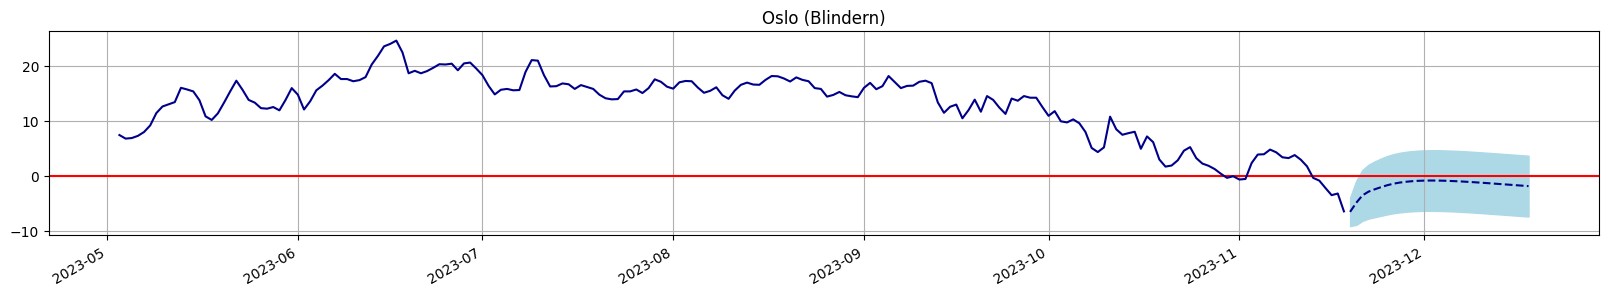

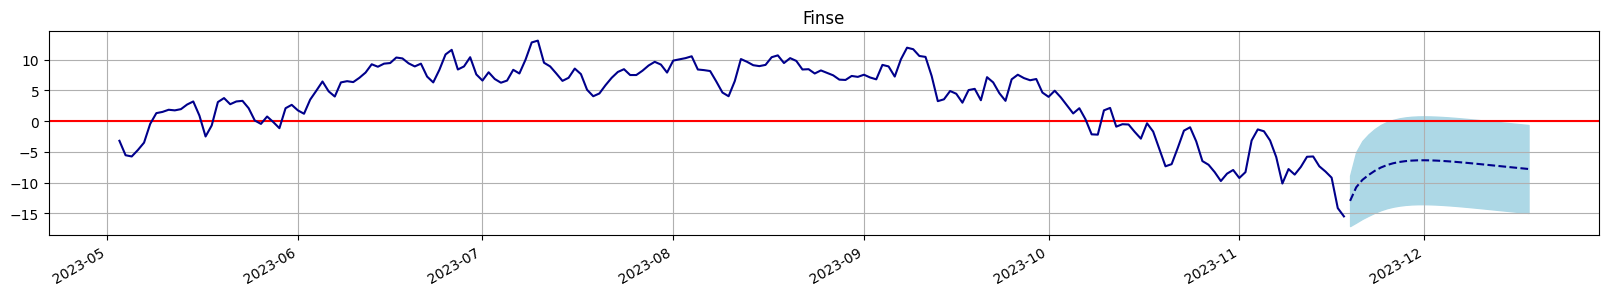

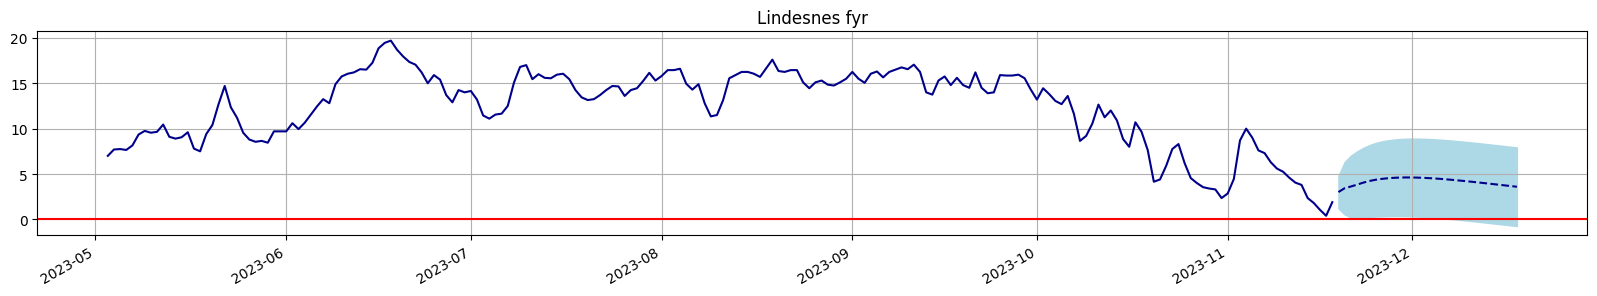

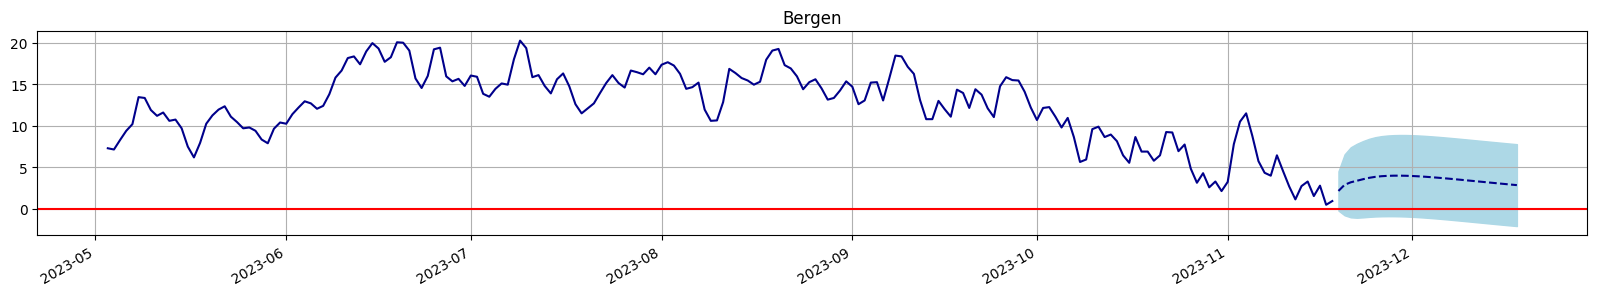

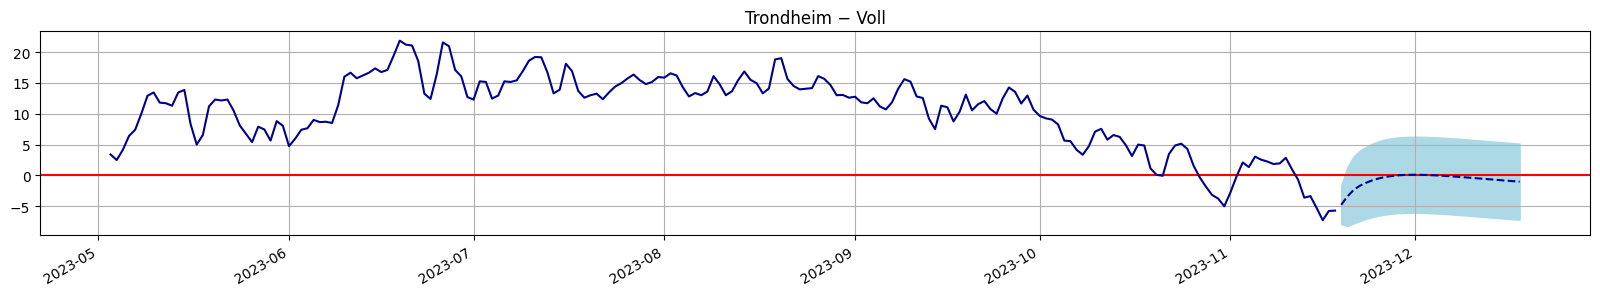

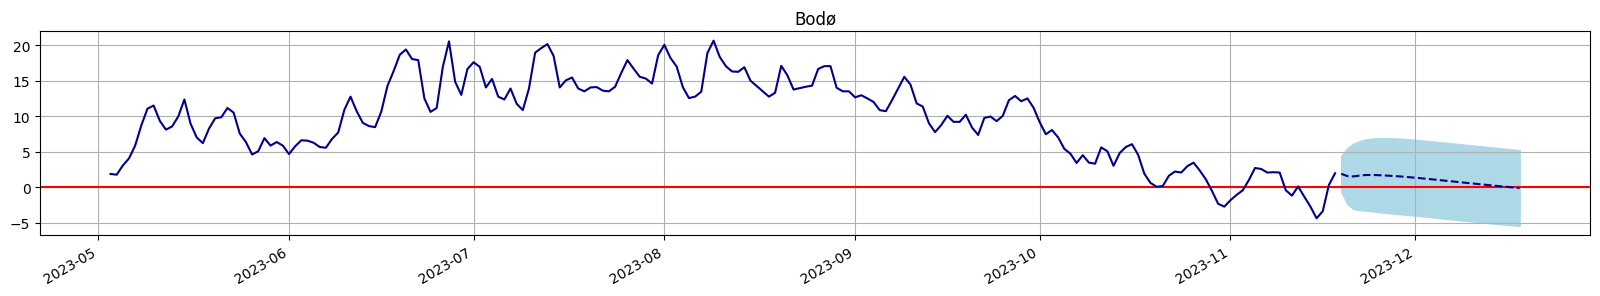

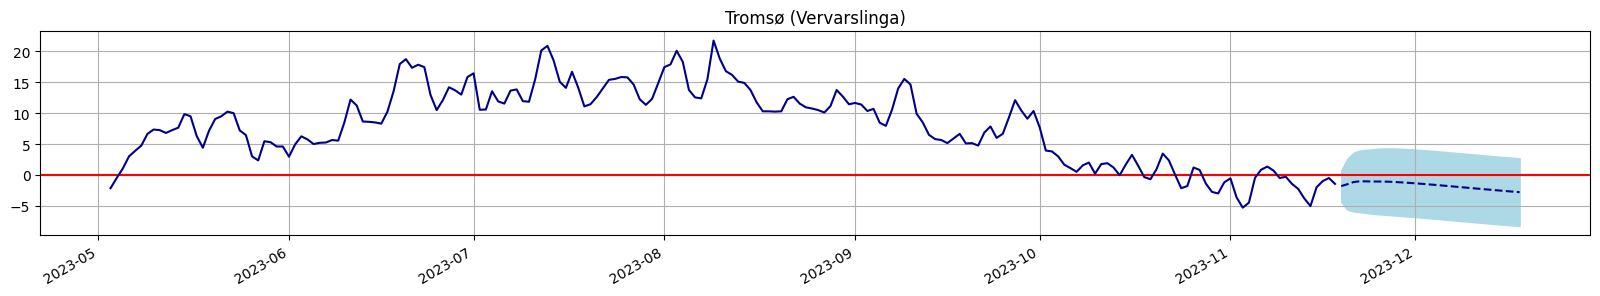

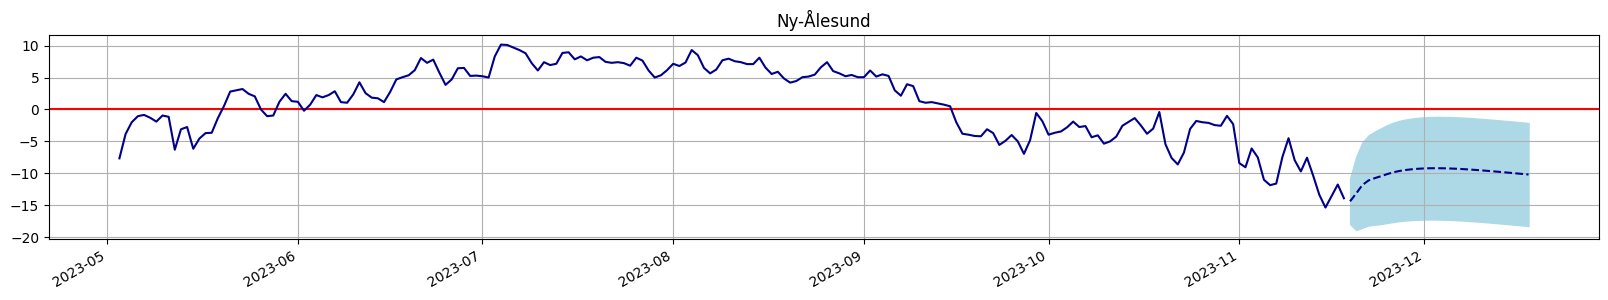

In [29]:
# Plot forecast and forecast interval
for k, (col, val) in enumerate(forecasts.items()):
    plt.figure(figsize=(20, 3))
    plt.axhline(y=0, color='r', linestyle='-')
    df.iloc[-200:, k].plot(
        color='darkblue',
        xlabel='',
        grid=True
        )
    plt.fill_between(val.get('interval').index,
                     val.get('interval').iloc[:, 0],
                     val.get('interval').iloc[:, 1],
                     color='lightblue'
                     )
    val.get('forecast').plot(
        style='--',
        color='darkblue',
        xlabel='',
        grid=True
        )
    plt.title(id_names.get(col))
    plt.show()